In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances

In [2]:
# Load the dataset
df = pd.read_excel('Online Retail.xlsx')

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nBasic statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

First few rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANG

In [3]:
# Data preprocessing
# Remove rows with missing values
df = df.dropna()

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create additional features
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['Hour'] = df['InvoiceDate'].dt.hour
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek

# Create session duration (time between consecutive purchases for each customer)
df = df.sort_values(['CustomerID', 'InvoiceDate'])
df['SessionDuration'] = df.groupby('CustomerID')['InvoiceDate'].diff().dt.total_seconds()

# Fill NaN session durations with median
df['SessionDuration'] = df['SessionDuration'].fillna(df['SessionDuration'].median())

# Create product category feature (using first two characters of StockCode)
df['ProductCategory'] = df['StockCode'].astype(str).str[:2]

# Prepare features for KNN
features = ['Hour', 'DayOfWeek', 'Quantity', 'UnitPrice', 'TotalAmount']
X = df[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

print("Processed features shape:", X_scaled.shape)
print("\nSample of processed features:")
print(X_scaled.head())

Processed features shape: (406829, 5)

Sample of processed features:
       Hour  DayOfWeek    Quantity  UnitPrice  TotalAmount
0 -1.198045  -0.835839  298.371565  -0.034920   180.460214
1 -1.198045  -0.835839 -298.468562  -0.034920  -180.555641
2  0.552541  -0.835839   -0.000247  -0.019627     0.011221
3  0.552541  -0.835839   -0.032415   0.011390    -0.007956
4  0.552541  -0.835839   -0.000247  -0.003036     0.043495


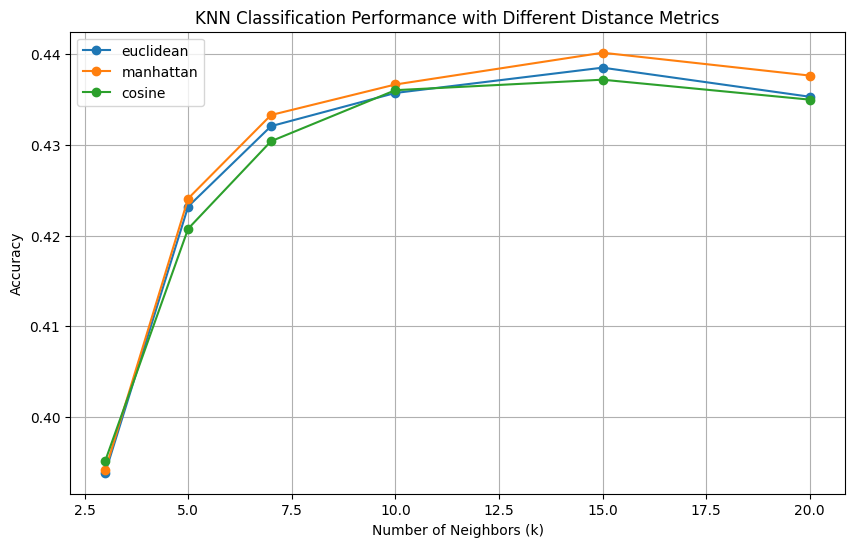


Classification Results:
       metric   k  accuracy
0   euclidean   3  0.393862
1   euclidean   5  0.423211
2   euclidean   7  0.432072
3   euclidean  10  0.435735
4   euclidean  15  0.438525
5   euclidean  20  0.435317
6   manhattan   3  0.394157
7   manhattan   5  0.424096
8   manhattan   7  0.433301
9   manhattan  10  0.436669
10  manhattan  15  0.440172
11  manhattan  20  0.437652
12     cosine   3  0.395177
13     cosine   5  0.420765
14     cosine   7  0.430413
15     cosine  10  0.436042
16     cosine  15  0.437197
17     cosine  20  0.434997


In [4]:
# Prepare target variable for classification (next product category)
y_class = df['ProductCategory']

# Encode product categories
le = LabelEncoder()
y_class_encoded = le.fit_transform(y_class)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class_encoded, test_size=0.2, random_state=42)

# Function to evaluate KNN with different distance metrics
def evaluate_knn_classification(X_train, X_test, y_train, y_test, k_values, metrics):
    results = []
    
    for metric in metrics:
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            results.append({
                'metric': metric,
                'k': k,
                'accuracy': accuracy
            })
    
    return pd.DataFrame(results)

# Evaluate different metrics and k values
k_values = [3, 5, 7, 10, 15, 20]
metrics = ['euclidean', 'manhattan', 'cosine']

classification_results = evaluate_knn_classification(X_train, X_test, y_train, y_test, k_values, metrics)

# Plot results
plt.figure(figsize=(10, 6))
for metric in metrics:
    metric_results = classification_results[classification_results['metric'] == metric]
    plt.plot(metric_results['k'], metric_results['accuracy'], marker='o', label=metric)

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Classification Performance with Different Distance Metrics')
plt.legend()
plt.grid(True)
plt.show()

print("\nClassification Results:")
print(classification_results)

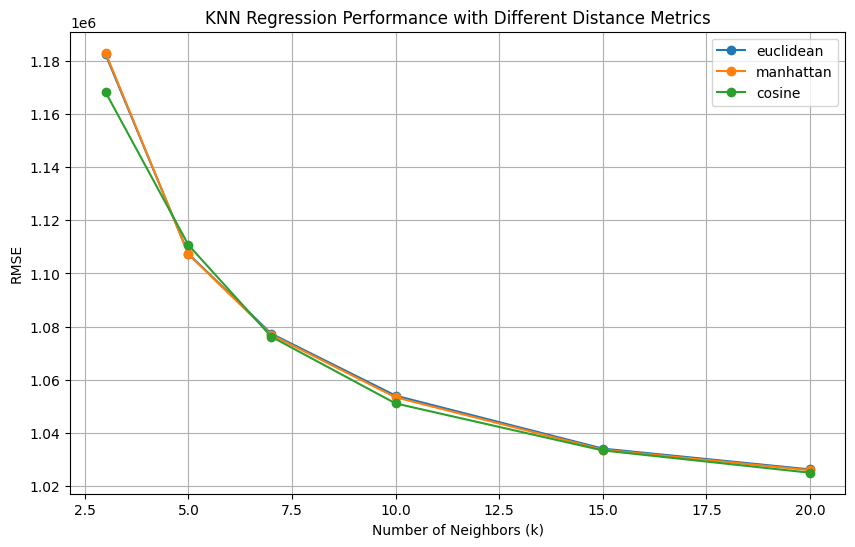


Regression Results:
       metric   k          rmse
0   euclidean   3  1.182525e+06
1   euclidean   5  1.107405e+06
2   euclidean   7  1.077321e+06
3   euclidean  10  1.053964e+06
4   euclidean  15  1.034008e+06
5   euclidean  20  1.026175e+06
6   manhattan   3  1.183145e+06
7   manhattan   5  1.107228e+06
8   manhattan   7  1.076912e+06
9   manhattan  10  1.053343e+06
10  manhattan  15  1.033619e+06
11  manhattan  20  1.025872e+06
12     cosine   3  1.168337e+06
13     cosine   5  1.110741e+06
14     cosine   7  1.076182e+06
15     cosine  10  1.051027e+06
16     cosine  15  1.033330e+06
17     cosine  20  1.024933e+06


In [5]:
# Prepare target variable for regression (session duration)
y_reg = df['SessionDuration']

# Split the data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)

# Function to evaluate KNN regression with different distance metrics
def evaluate_knn_regression(X_train, X_test, y_train, y_test, k_values, metrics):
    results = []
    
    for metric in metrics:
        for k in k_values:
            knn = KNeighborsRegressor(n_neighbors=k, metric=metric)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            results.append({
                'metric': metric,
                'k': k,
                'rmse': rmse
            })
    
    return pd.DataFrame(results)

# Evaluate regression model
regression_results = evaluate_knn_regression(X_train_reg, X_test_reg, y_train_reg, y_test_reg, k_values, metrics)

# Plot regression results
plt.figure(figsize=(10, 6))
for metric in metrics:
    metric_results = regression_results[regression_results['metric'] == metric]
    plt.plot(metric_results['k'], metric_results['rmse'], marker='o', label=metric)

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.title('KNN Regression Performance with Different Distance Metrics')
plt.legend()
plt.grid(True)
plt.show()

print("\nRegression Results:")
print(regression_results)

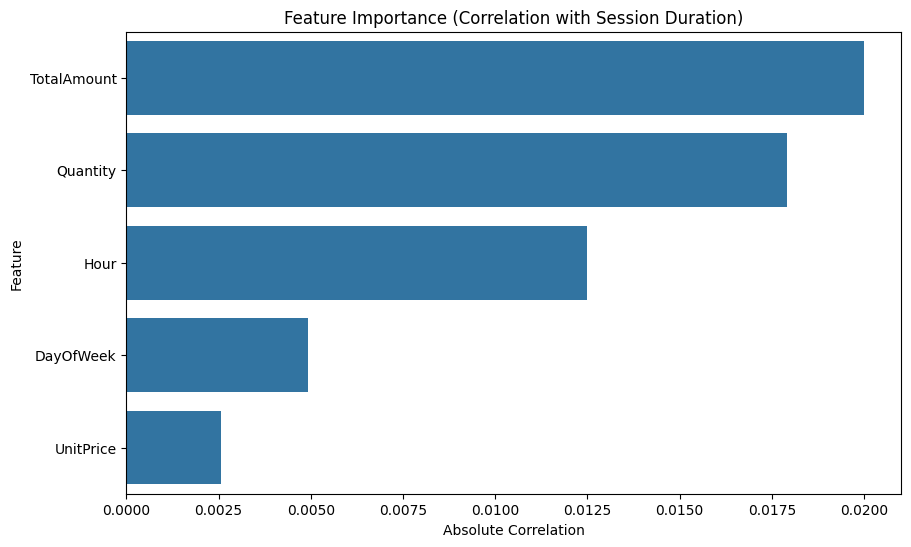

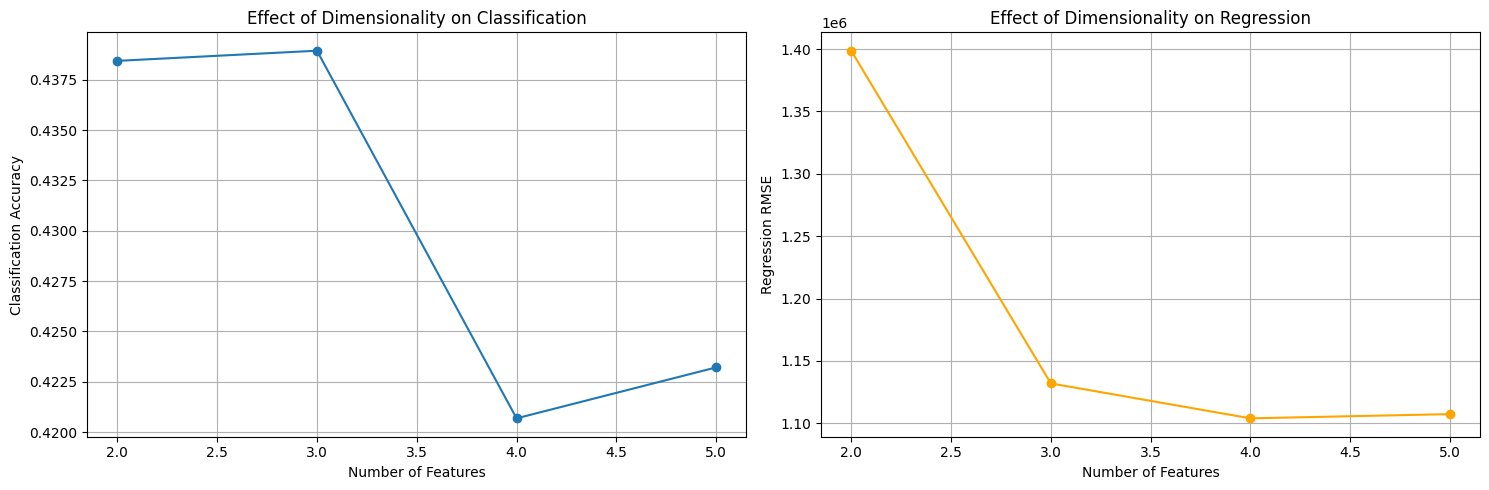


Dimensionality Analysis Results:
   n_features  classification_accuracy  regression_rmse
0           2                 0.438439     1.398686e+06
1           3                 0.438943     1.132016e+06
2           4                 0.420679     1.104026e+06
3           5                 0.423211     1.107407e+06


In [6]:
# Analyze feature importance using correlation with target variables
correlations = pd.DataFrame()
correlations['Feature'] = features
correlations['Correlation_with_SessionDuration'] = [abs(X[feature].corr(df['SessionDuration'])) for feature in features]

# Sort by absolute correlation
correlations = correlations.sort_values('Correlation_with_SessionDuration', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation_with_SessionDuration', y='Feature', data=correlations)
plt.title('Feature Importance (Correlation with Session Duration)')
plt.xlabel('Absolute Correlation')
plt.show()

# Analyze dimensionality effects
def evaluate_dimensionality(X_train, X_test, y_train, y_test, feature_counts):
    results = []
    
    for n_features in feature_counts:
        # Select top n features
        top_features = correlations['Feature'].head(n_features).values
        X_train_subset = X_train[top_features]
        X_test_subset = X_test[top_features]
        
        # Evaluate classification
        knn_class = KNeighborsClassifier(n_neighbors=5)
        knn_class.fit(X_train_subset, y_train)
        class_acc = accuracy_score(y_test, knn_class.predict(X_test_subset))
        
        # Evaluate regression
        knn_reg = KNeighborsRegressor(n_neighbors=5)
        knn_reg.fit(X_train_subset, y_train_reg)
        reg_rmse = np.sqrt(mean_squared_error(y_test_reg, knn_reg.predict(X_test_subset)))
        
        results.append({
            'n_features': n_features,
            'classification_accuracy': class_acc,
            'regression_rmse': reg_rmse
        })
    
    return pd.DataFrame(results)

# Evaluate different feature counts
feature_counts = range(2, len(features) + 1)
dimensionality_results = evaluate_dimensionality(
    X_train, X_test, y_train, y_test, feature_counts
)

# Plot dimensionality effects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(dimensionality_results['n_features'], 
         dimensionality_results['classification_accuracy'], 
         marker='o')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('Classification Accuracy')
ax1.set_title('Effect of Dimensionality on Classification')
ax1.grid(True)

ax2.plot(dimensionality_results['n_features'], 
         dimensionality_results['regression_rmse'], 
         marker='o', color='orange')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Regression RMSE')
ax2.set_title('Effect of Dimensionality on Regression')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\nDimensionality Analysis Results:")
print(dimensionality_results)